In [4]:
!pip3 install transformers


  Using cached transformers-4.11.3-py3-none-any.whl (2.9 MB)
  Using cached huggingface_hub-0.0.19-py3-none-any.whl (56 kB)
  Using cached sacremoses-0.0.46-py3-none-any.whl (895 kB)
  Using cached tokenizers-0.10.3-cp39-cp39-win_amd64.whl (2.0 MB)
  Using cached filelock-3.3.1-py3-none-any.whl (9.7 kB)
  Using cached packaging-21.0-py3-none-any.whl (40 kB)
  Using cached PyYAML-6.0-cp39-cp39-win_amd64.whl (151 kB)
  Using cached pyparsing-2.4.7-py2.py3-none-any.whl (67 kB)


In [6]:
import transformers.DistilBertModel

ModuleNotFoundError: No module named 'transformers.DistilBertModel'

In [ ]:
!pip3 install tensorflow_hub

In [2]:
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

In [137]:
import tokenization # tokenization.py
import tensorflow as tf
import tensorflow_hub as hub
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import nltk
import transformers
import re
import matplotlib.pyplot as plt

In [140]:
# remove stopwords: the,a,an etc.
nltk.download("stopwords")
from nltk.corpus import stopwords
sw = stopwords.words("english")

def pre_processing(data):
    # lowercase text
    data = data.apply(lambda x: " ".join(i.lower() for i in  str(x).split()))
#     # remove numeric values
#     data = data.str.replace("\d","")
#     # remove punctuations
#     data = data.str.replace("[^\w\s]","")
    # remove stopwords: the,a,an etc.
    data = data.apply(lambda x: " ".join(i for i in x.split() if i not in sw))
    data = data.apply(lambda x: re.sub("⇓","",x))
    
    return data

[nltk_data] Downloading package stopwords to /home/ragou/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [145]:
data_file = "../datas/all_data_clean.txt"
dtf = pd.read_csv(data_file, sep = "\|\|", engine = "python")

In [146]:
dtf

,ID,Gene,Variation,Class,Text,Score
0,0,FAM58A,truncating mutations,1,"here, we deorphanize cdk10 by identifying cyc...",2
1,1,CBL,w802*,2,the c-cbl loh also positively correlated wit...,1
2,2,CBL,q249e,2,the c-cbl loh also positively correlated wit...,1
3,3,CBL,n454d,3,"most of the changes were novel, although 4 c...",1
4,4,CBL,l399v,4,all mutations from the second group were pre...,1
...,...,...,...,...,...,...
3311,3316,RUNX1,d171n,4,21–29 the vast majority of aml1 mutations wer...,1
3312,3317,RUNX1,a122*,1,(a) spleen from morbid mice/d171n (left) and...,2
3313,3318,RUNX1,fusions,1,lpxn is preferentially expressed in hematopo...,1
3314,3319,RUNX1,r80c,4,") conversely, mutations mapping to the first ...",1


In [148]:
text_y = dtf["Text"]
text_y

0        here, we deorphanize cdk10 by identifying cyc...
1         the c-cbl loh also positively correlated wit...
2         the c-cbl loh also positively correlated wit...
3         most of the changes were novel, although 4 c...
4         all mutations from the second group were pre...
                              ...                        
3311     21–29 the vast majority of aml1 mutations wer...
3312      (a) spleen from morbid mice/d171n (left) and...
3313      lpxn is preferentially expressed in hematopo...
3314     ) conversely, mutations mapping to the first ...
3315      mutation analysis in fpd/aml pedigrees. elec...
Name: Text, Length: 3316, dtype: object

In [149]:
X = pre_processing(text_y)

In [150]:
X

0       here, deorphanize cdk10 identifying cyclin m, ...
1       c-cbl loh also positively correlated egfr met ...
2       c-cbl loh also positively correlated egfr met ...
3       changes novel, although 4 cases r420q previous...
4       mutations second group predicted benign accord...
                              ...                        
3311    21–29 vast majority aml1 mutations located run...
3312    (a) spleen morbid mice/d171n (left) normal mic...
3313    lpxn preferentially expressed hematopoietic ce...
3314    ) conversely, mutations mapping first dna inte...
3315    mutation analysis fpd/aml pedigrees. electroph...
Name: Text, Length: 3316, dtype: object

In [151]:
dataset = dtf.drop(columns = ["Score"], axis = 0)

In [11]:
dataset.columns = ["ID","Gene","Variation","Class","Text"]

In [152]:
dataset

,ID,Gene,Variation,Class,Text
0,0,FAM58A,truncating mutations,1,"here, we deorphanize cdk10 by identifying cyc..."
1,1,CBL,w802*,2,the c-cbl loh also positively correlated wit...
2,2,CBL,q249e,2,the c-cbl loh also positively correlated wit...
3,3,CBL,n454d,3,"most of the changes were novel, although 4 c..."
4,4,CBL,l399v,4,all mutations from the second group were pre...
...,...,...,...,...,...
3311,3316,RUNX1,d171n,4,21–29 the vast majority of aml1 mutations wer...
3312,3317,RUNX1,a122*,1,(a) spleen from morbid mice/d171n (left) and...
3313,3318,RUNX1,fusions,1,lpxn is preferentially expressed in hematopo...
3314,3319,RUNX1,r80c,4,") conversely, mutations mapping to the first ..."


In [175]:
Y_D = pd.get_dummies(dataset['Class']).values
XD_train, XD_test, YD_train, YD_test = train_test_split(X, Y_D, test_size = 0.2, random_state = 42, stratify=Y_D)
print(XD_train.shape, YD_train.shape)
print(XD_test.shape, YD_test.shape)

(2652,) (2652, 9)
(664,) (664, 9)


In [176]:
XD_test.head(2)

893     results 80 tumors (%) pdgfra mutation: 66 exon...
2819    addition, n319t nh2 terminus brca2 included no...
Name: Text, dtype: object

In [15]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')

In [16]:
m_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2'
bert_layer = hub.KerasLayer(m_url, trainable=True)

INFO:absl:Using /tmp/tfhub_modules to cache modules.


In [111]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
        
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len-len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence) + [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
        
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [179]:
def build_model(bert_layer, max_len=250):
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")
    
    pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    
    #clf_output = sequence_output[:, 0, :]
    
    # CNN model
    
    net = tf.keras.layers.Conv1D(64, (5), activation='relu')(sequence_output)
    net = tf.keras.layers.MaxPooling1D(2)(net)
    
#     net = tf.keras.layers.Conv1D(64, (5), activation='relu')(net)
#     net = tf.keras.layers.GlobalMaxPooling1D()(net)
    

    net = tf.keras.layers.Dense(20, activation="relu")(net)
    net = tf.keras.layers.Flatten()(net)    
    net = tf.keras.layers.Dropout(0.1)(net)
    out = tf.keras.layers.Dense(9, activation="softmax")(net)
    
    model = tf.keras.models.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [180]:
train_input = bert_encode(XD_train.head(10), tokenizer, max_len=250)
test_input = bert_encode(XD_test, tokenizer, max_len=250)

In [181]:
model = build_model(bert_layer, max_len=250)
model.summary()

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 250)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 250)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 250)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        multiple             109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]          

In [118]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model_bert.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3,verbose=1)

train_sh = model.fit(
    train_input, YD_train[:10],
    validation_split=0.2,
    epochs=3,
    callbacks=[checkpoint, earlystopping],
    batch_size=32,
    verbose=1
)

Epoch 1/3
1/1 [==============================] - 52s 52s/step - loss: 2.5736 - accuracy: 0.0000e+00 - val_loss: 4.3942 - val_accuracy: 0.0000e+00

Epoch 00001: val_accuracy improved from -inf to 0.00000, saving model to model_bert.h5
Epoch 2/3
1/1 [==============================] - 39s 39s/step - loss: 2.0751 - accuracy: 0.5000 - val_loss: 2.5006 - val_accuracy: 0.0000e+00

Epoch 00002: val_accuracy did not improve from 0.00000
Epoch 3/3
1/1 [==============================] - 39s 39s/step - loss: 1.7821 - accuracy: 0.3750 - val_loss: 11.6123 - val_accuracy: 0.5000

Epoch 00003: val_accuracy improved from 0.00000 to 0.50000, saving model to model_bert.h5


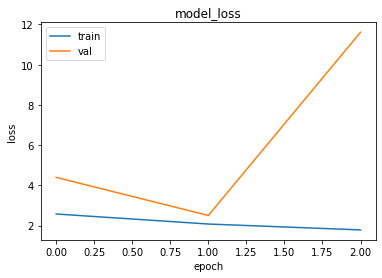

<Figure size 432x288 with 0 Axes>

In [128]:
plt.plot(train_sh.history['loss'])
plt.plot(train_sh.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc = 'upper left')
plt.show()
plt.savefig("loss_plot.PNG")

In [129]:
!pwd

/home/ragou/repo/github/RAPMC/notebook


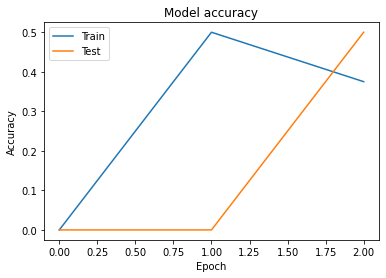

In [131]:
plt.plot(train_sh.history['accuracy'])
plt.plot(train_sh.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig("acc_plot.jpg")


# Pretrained BERT


In [37]:
!conda list


# packages in environment at C:\Users\Radja\miniconda3\envs\tf_gpu_env:
#
# Name                    Version                   Build  Channel
_tflow_select             2.3.0                       mkl  
abseil-cpp                20210324.2           hd77b12b_0  
absl-py                   0.14.1                   pypi_0    pypi
aiohttp                   3.7.4.post0      py39h2bbff1b_2  
astor                     0.8.1            py39haa95532_0  
astunparse                1.6.3                      py_0  
async-timeout             3.0.1            py39haa95532_0  
attrs                     21.2.0             pyhd3eb1b0_0  
backcall                  0.2.0              pyhd3eb1b0_0  
blas                      1.0                         mkl  
blinker                   1.4              py39haa95532_0  
boto3                     1.18.21            pyhd3eb1b0_0  
botocore                  1.21.41            pyhd3eb1b0_1  
bottleneck                1.3.2            py39h7cc1a96_1  
brotlipy     

In [6]:

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import re

import warnings

warnings.filterwarnings('ignore')

from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
import nltk
import torch
from keras.preprocessing.text import Tokenizer
import transformers as ppb

import os
import sys
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import seaborn as sns

In [4]:
features = pd.read_pickle("../../data/array_data_scibert.pkl")

In [35]:
features.to_pickle("../../data/array_data_scibert_prot4.pkl", protocol=4)

In [32]:
features.loc[0][features.loc[0] > 2]

422      15.960649
1190     15.273297
1958     15.153947
2726     15.898499
3494     15.289441
4262     15.623961
4994      2.063572
5030     16.016623
5798     14.925836
6566     15.593343
7334     15.621113
8102     15.613622
8870     15.375978
9638     16.531483
10370     2.049575
10406    15.744185
11174    15.736642
11942    15.883093
12710    16.302942
13478    16.083614
14246    15.463799
15014    15.688974
Name: 0, dtype: float64

In [2]:
scriptpath = "../scripts/"

# Add the directory containing your module to the Python path (wants absolute paths)
sys.path.append(os.path.abspath(scriptpath))

In [3]:
import article_cleaner

In [2]:
tf.__version__

'2.6.0'

In [4]:
nltk.download("stopwords")
from nltk.corpus import stopwords
sw = stopwords.words("english")

def pre_processing(data):
    # lowercase text
    data = data.apply(lambda x: " ".join(i.lower() for i in  str(x).split()))
#     # remove numeric values
#     data = data.str.replace("\d","")
#     # remove punctuations
#     data = data.str.replace("[^\w\s]","")
    # remove stopwords: the,a,an etc.
    data = data.apply(lambda x: " ".join(i for i in x.split() if i not in sw))
    data = data.apply(lambda x: re.sub("\.|,|\)|\(","",x))
    
    return data


[nltk_data] Downloading package stopwords to /home/ragou/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [372]:
def get_chunks(text, size):
    length_text = len(text)
    final = []
    for i in range(0, length_text, size):
        final.append([" ".join(text[i:i+size])])
    return final


def get_features(article, tokenizer):
    token = []
    max_len = 0
    
    for chunk in lemm(article):
        token.append(tokenizer.encode(chunk, add_special_tokens=True))
        
    for i in token:
        if len(i) > max_len:
            max_len = len(i)

    padded = np.array([i + [0]*(max_len-len(i)) for i in token])
        
    attention_mask = np.where(padded != 0, 1, 0)
    attention_mask.shape
    
    input_ids = torch.tensor(padded)  
    attention_mask = torch.tensor(attention_mask)


    with torch.no_grad():
        last_hidden_states = model(input_ids, attention_mask=attention_mask)
        
    features = last_hidden_states[0][:,0,:].numpy()
    
    print("SHAPE" ,features.shape)
    tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
    tsne_results = tsne.fit_transform(features.T)
    
    return tsne_results.T.flatten()



def lemm(text):
    lemmatizer = WordNetLemmatizer()
    temp = []
    list_words = list(set(word_tokenize(text)))
    for word in list_words:
        temp.append(lemmatizer.lemmatize(word))
    return list(set(temp))
            
def get_outlier(line):
    length = lemm(line["Text"])
    
    if length > 512:
        return line["ID"]
    


In [6]:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')
#model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')
# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [43]:
len(features(["article"], tokenizer))

(1, 768)


768

In [30]:
clean_dtf = pd.read_csv("../datas/all_data_clean_011.txt", sep = "\|\|", engine = "python")
clean_dtf_one = pd.read_csv("../datas/all_data_clean_010.txt", sep = "\|\|", engine = "python")

In [31]:
text_one = clean_dtf_one["Text"]
clean_text_one = pre_processing(text_one)
clean_dtf_one["Text"] = clean_text_one

In [32]:
clean_dtf_one

,ID,Gene,Variation,Class,Text,Score
0,0,FAM58A,truncating mutations,1,mutations gene predict absence truncation cycl...,2
1,1,CBL,w802*,2,using select c-cbl somatic mutations s80n/h94y...,1
2,2,CBL,q249e,2,using select c-cbl somatic mutations s80n/h94y...,1
3,3,CBL,n454d,3,15 apart n454d residues affected missense muta...,1
4,4,CBL,l399v,4,finally third group constituted mutations l399...,1
...,...,...,...,...,...,...
3311,3316,RUNX1,d171n,4,confirm involvement aml1 mutations hematopoiet...,1
3312,3317,RUNX1,a122*,1,histopathologic findings b spleen d liver f ki...,2
3313,3318,RUNX1,fusions,1,out-of-frame fusions rhd runx1 retained early ...,1
3314,3319,RUNX1,r80c,4,runx1 mutants r80c k83n k83e showed strong aff...,1


In [8]:
text = clean_dtf["Text"]
clean_text = pre_processing(text)

In [9]:
clean_dtf

,ID,Gene,Variation,Class,Text,Score
0,0,FAM58A,truncating mutations,1,mutations in this gene that predict absence o...,2
1,1,CBL,w802*,2,using select c-cbl somatic mutations such as ...,1
2,2,CBL,q249e,2,using select c-cbl somatic mutations such as ...,1
3,3,CBL,n454d,3,"15 apart from n454d, all residues affected by ...",1
4,4,CBL,l399v,4,"finally, the third group constituted mutatio...",1
...,...,...,...,...,...,...
3311,3316,RUNX1,d171n,4,to confirm the involvement of aml1 mutations ...,1
3312,3317,RUNX1,a122*,1,"histopathologic findings of (b) spleen, (d) l...",2
3313,3318,RUNX1,fusions,1,"out-of-frame fusions, in which the rhd of run...",1
3314,3319,RUNX1,r80c,4,"these runx1 mutants, r80c, k83n, and k83e sho...",1


In [10]:
clean_dtf["Text"] = clean_text

In [161]:
clean_text.apply(lambda x: print(lemm(x)))

84 968
None
213 3319
None
213 3319
None
125 1308
None
38 367
None
38 367
None
47 440
None
571 9164
None
481 12298
None
441 11659
None
38 367
None
403 7811
None
1003 23660
None
336 5375
None
30 227
None
348 7152
None
76 750
None
32 303
None
76 763
None
97 1136
None
261 4249
None
52 503
None
38 367
None
57 495
None
101 916
None
57 495
None
379 5458
None
432 7172
None
252 3086
None
432 7172
None
432 7172
None
1616 41346
None
432 7172
None
875 20932
None
810 18025
None
389 7111
None
93 1217
None
67 875
None
83 1150
None
62 816
None
62 816
None
83 1059
None
67 875
None
1076 22017
None
31 311
None
55 1368
None
474 7024
None
55 1368
None
1128 34655
None
31 311
None
97 1331
None
97 1331
None
406 7427
None
105 2023
None
97 1331
None
55 1368
None
79 961
None
91 1839
None
97 1331
None
55 542
None
106 2020
None
242 3841
None
77 787
None
151 1988
None
55 1368
None
89 1175
None
151 1988
None
721 14239
None
820 19899
None
721 14239
None
509 7284
None
23 214
None
116 1382
None
27 264
None
275 2890
Non

1052 21656
None
210 2231
None
23 165
None
30 307
None
66 706
None
270 4830
None
57 474
None
234 2571
None
101 1073
None
66 706
None
245 2597
None
66 706
None
246 3910
None
138 2122
None
26 265
None
537 9627
None
66 706
None
91 1142
None
295 3925
None
524 11239
None
139 1633
None
543 10972
None
34 341
None
773 14087
None
638 12683
None
196 2308
None
334 6603
None
185 2011
None
194 2546
None
257 3249
None
151 3266
None
165 3248
None
151 3266
None
136 1970
None
55 557
None
202 3890
None
83 876
None
399 5266
None
236 4262
None
32 223
None
138 2962
None
165 3248
None
47 459
None
47 459
None
148 2054
None
57 703
None
57 703
None
210 3062
None
138 2962
None
64 618
None
505 9231
None
158 3180
None
74 668
None
165 3248
None
412 7535
None
151 3266
None
305 4067
None
151 3266
None
47 459
None
138 2962
None
476 7425
None
138 2962
None
94 1296
None
86 974
None
138 2962
None
580 9772
None
508 8299
None
112 1558
None
102 1007
None
287 3371
None
189 1866
None
138 2962
None
151 3266
None
172 3480
None


0      None
1      None
2      None
3      None
4      None
       ... 
995    None
996    None
997    None
998    None
999    None
Name: Text, Length: 1000, dtype: object

In [33]:
poubelle = clean_dtf_one.apply(lambda line: get_outlier(line), axis = 1)

In [34]:
id_drop = poubelle.dropna().astype(int)

In [35]:
id_drop

12        12
31        31
33        33
34        34
43        43
        ... 
3242    3247
3249    3254
3291    3296
3298    3303
3311    3316
Length: 224, dtype: int64

# PCA TSNE

In [374]:
import plotly as px
import matplotlib.pyplot as plt
import time

In [150]:
len(lemm(clean_text[0]))

84

In [375]:
start  = time.time()
vec = clean_text[:100].apply(lambda x: get_features(x, tokenizer))
print("Done in :", time.time() - start)

SHAPE (84, 768)
SHAPE (213, 768)
SHAPE (213, 768)
SHAPE (125, 768)
SHAPE (38, 768)
SHAPE (38, 768)
SHAPE (47, 768)
SHAPE (571, 768)
SHAPE (481, 768)
SHAPE (441, 768)
SHAPE (38, 768)
SHAPE (403, 768)
SHAPE (1003, 768)
SHAPE (336, 768)
SHAPE (30, 768)
SHAPE (348, 768)
SHAPE (76, 768)
SHAPE (32, 768)
SHAPE (76, 768)
SHAPE (97, 768)
SHAPE (261, 768)
SHAPE (52, 768)
SHAPE (38, 768)
SHAPE (57, 768)
SHAPE (101, 768)
SHAPE (57, 768)
SHAPE (379, 768)
SHAPE (432, 768)
SHAPE (252, 768)
SHAPE (432, 768)
SHAPE (432, 768)
SHAPE (1616, 768)
SHAPE (432, 768)
SHAPE (875, 768)
SHAPE (810, 768)
SHAPE (389, 768)
SHAPE (93, 768)
SHAPE (67, 768)
SHAPE (83, 768)
SHAPE (62, 768)
SHAPE (62, 768)
SHAPE (83, 768)
SHAPE (67, 768)
SHAPE (1076, 768)
SHAPE (31, 768)
SHAPE (55, 768)
SHAPE (474, 768)
SHAPE (55, 768)
SHAPE (1128, 768)
SHAPE (31, 768)
SHAPE (97, 768)
SHAPE (97, 768)
SHAPE (406, 768)
SHAPE (105, 768)
SHAPE (97, 768)
SHAPE (55, 768)
SHAPE (79, 768)
SHAPE (91, 768)
SHAPE (97, 768)
SHAPE (55, 768)
SHAPE (10

In [377]:
x_input = pd.DataFrame(list(vec))

In [279]:
dtf  = pd.concat([pd.DataFrame(vec[0]), pd.DataFrame(vec[1])])

In [272]:
dtf = pd.DataFrame(vec.values)
dtf

,0
0,"[[-0.17495823, -0.047251303, 0.08547299, -0.23..."
1,"[[-0.29663602, -0.048084375, -0.19339488, -0.1..."


In [312]:
pca = PCA(0.99)


In [182]:
vec

[-0.30300143,
 0.022768296,
 -0.2102704,
 -0.27946776,
 0.003865334,
 0.00037628558,
 0.12623006,
 0.2451834,
 -0.23199065,
 -0.37141207,
 -0.14055876,
 -0.07224036,
 0.11907644,
 0.26206806,
 -0.02275215,
 0.3110061,
 -0.08479783,
 0.0017293976,
 0.1917347,
 -0.032649785,
 -0.22506677,
 -0.35503232,
 -0.12787299,
 -0.12504528,
 -0.11132049,
 -0.21208,
 -0.19066194,
 0.110723935,
 0.12674204,
 -0.01680362,
 -0.06544068,
 0.2234552,
 -0.2211286,
 -0.23936544,
 0.10907316,
 0.0993568,
 -0.07285218,
 -0.114121474,
 -0.12802336,
 -0.10470481,
 -0.22364822,
 0.03407946,
 0.07495353,
 0.17245778,
 -0.10355012,
 -0.07774525,
 -2.1201088,
 0.046292488,
 -0.33589262,
 0.054205175,
 0.24057956,
 -0.049570806,
 0.23928027,
 0.26276356,
 0.25116017,
 0.2676981,
 -0.22528663,
 0.3404603,
 -0.042630654,
 0.005517002,
 0.35145485,
 0.051978648,
 -0.13102157,
 -0.2091414,
 0.32465097,
 0.0151490355,
 0.0490305,
 0.09835112,
 -0.30338332,
 0.3270958,
 -0.322596,
 -0.064438276,
 0.23291215,
 0.23402478,

In [346]:
tf.config.experimental.list_physical_devices('CPU')

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [328]:
X1 = pca.fit_transform(vec.T)

In [329]:
X1.shape

(84, 73)

In [368]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=250)
tsne_results = tsne.fit_transform(vec.T)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 768 samples in 0.001s...
[t-SNE] Computed neighbors for 768 samples in 0.120s...
[t-SNE] Computed conditional probabilities for sample 768 / 768
[t-SNE] Mean sigma: 0.397150


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/ragou/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3418, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-369-a33c7e8ad8f0>", line 2, in <module>
    tsne_results = tsne.fit_transform(vec.T)
  File "/home/ragou/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py", line 1108, in fit_transform
    embedding = self._fit(X)
  File "/home/ragou/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py", line 1004, in _fit
    return self._tsne(
  File "/home/ragou/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py", line 1056, in _tsne
    params, kl_divergence, it = _gradient_descent(obj_func, params, **opt_args)
  File "/home/ragou/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py", line 398, in _gradient_descent
    error, grad = objective(p, *args, **kwargs)
  File "/home/ragou/.local/lib/python3.8/site-packages/sklearn/manifold/_t_s


KeyboardInterrupt



In [319]:
tsne_results.shape

(768, 3)

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=tsne_results[:,1], y=tsne_results[:,0],
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.3
)

<AxesSubplot:>

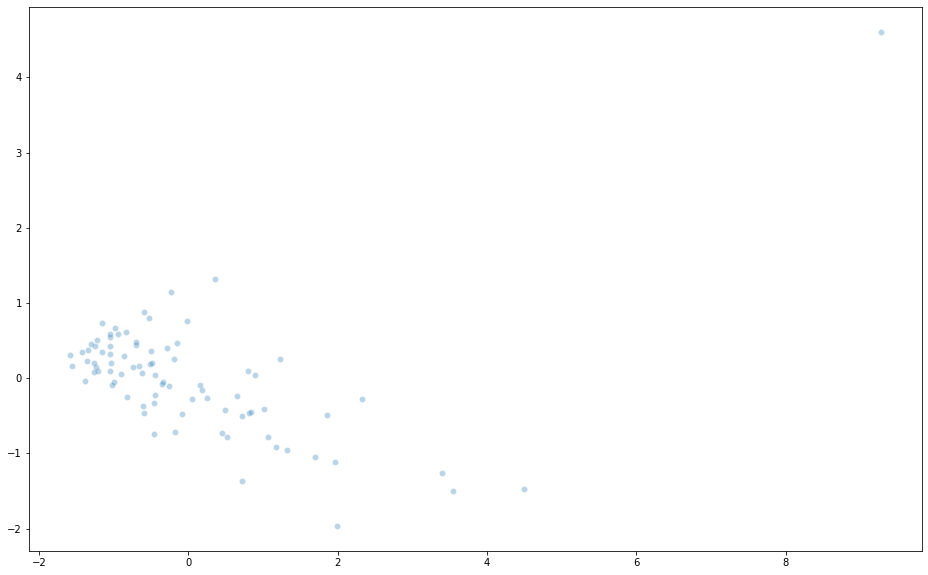

In [331]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=X1[:,0], y=X1[:,1],
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.3
)

In [103]:
X1.shape

(968, 16)

In [94]:
fig = px.scatter_matrix(
    X1,
)
fig.update_traces(diagonal_visible=False)
fig.show()

AttributeError: module 'plotly' has no attribute 'scatter_matrix'

In [36]:
dtf_drop = clean_dtf[clean_dtf["ID"].isin(id_drop)]

In [39]:
(dtf_drop["Score"] == 1).sum()

127

In [29]:
text_reclean = dtf_drop.head(2).apply(lambda line: article_cleaner.extract_match(line), axis = 1)


KeyboardInterrupt: 

In [27]:
list(text_reclean)

[('results:we identified 3 279 aml/mds patients expressingcbl exon 8/9 deletion mutants three four cases diagnosis expressed deleted transcripts missing exon 8 exon 8/9 aml/mds patients identified cbl mutants belonged core bindingfactor 11q deletion aml subtypes functionally cbl negatively regulated fmslike tyrosine kinase 3 flt3 activity interacted human flt3 via autophosphorylation sitesy589 andy599 colocalized vivo cbl-70z carrying internal deletion 17 amino acids isolated 70z/ 3 mouse pre-b-cell lymphoma cell line 4 cbl-70z deregulates cellular tyrosine kinase machinery nih3t3 serumstarved cells expressing cbl-70z showed significantly increased endothelial growth factor receptor egfr kinase activity egf stimulation 5 additional screenings aml patients revealed cases cbl mutations including internal deletions exon 8 point mutations targeting g375 10 11 activating flt3 mutations represent one common genetic alterations aml associated poor prognosis 12 finally cbl deletion mutants cbl

In [22]:
dtf_reclean = pd.DataFrame(list(text_reclean), columns = ["Text","Score"])

ValueError: Shape of passed values is (366, 1), indices imply (366, 2)

In [ ]:
dtf_reclean

In [180]:
(all_length > 512).sum()

366

In [6]:
chunked_text = clean_text.apply(lambda x: get_chunks(x.split(), 100))

In [51]:
len(features(chunked_text[9], tokenizer))

(19, 768)


14592

In [16]:
tokenized = short.apply(lambda line: tokenizer.encode(line, add_special_tokens=True))

In [69]:
tokenized.values[0]

[101,
 2182,
 2139,
 2953,
 21890,
 3490,
 4371,
 3729,
 2243,
 10790,
 12151,
 22330,
 20464,
 2378,
 1049,
 4031,
 6904,
 2213,
 27814,
 2050,
 8031,
 4256,
 14494,
 4962,
 16014,
 6438,
 19817,
 4609,
 10719,
 22330,
 20464,
 2378,
 3378,
 2732,
 8715,
 3005,
 2838,
 2421,
 11756,
 19962,
 2850,
 6593,
 8516,
 2100,
 10093,
 19281,
 3372,
 9825,
 2019,
 23924,
 18400,
 25125,
 15451,
 14192,
 10708,
 21770,
 10624,
 9096,
 3995,
 2271,
 3801,
 2184,
 2174,
 4972,
 22330,
 20464,
 2378,
 26835,
 19009,
 2732,
 8715,
 3961,
 4242,
 8290,
 6887,
 16515,
 13874,
 2036,
 5159,
 2440,
 1011,
 3091,
 22330,
 20464,
 2378,
 3729,
 2243,
 10790,
 8171,
 5228,
 17395,
 8336,
 4414,
 1055,
 2487,
 2050,
 7718,
 2367,
 11163,
 22694,
 3729,
 2243,
 10790,
 22330,
 20464,
 2378,
 14802,
 4522,
 4962,
 11867,
 2140,
 102]

In [379]:
labels = pd.get_dummies(clean_dtf['Class'].head(100)).values
Y = clean_dtf['Class'].head(100)

In [380]:
labels

array([[1, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0, 0, 0],
       [0,

In [91]:
Y

0     1
1     2
2     2
3     3
4     4
     ..
95    4
96    4
97    2
98    4
99    4
Name: Class, Length: 100, dtype: int64

In [121]:
features

array([[-0.5035406 , -0.00647518, -0.21705078, ..., -0.5287751 ,
         0.2916012 ,  0.08589556],
       [-0.5125765 , -0.13349567, -0.28608534, ..., -0.38054252,
         0.4418598 ,  0.18841559],
       [-0.5125765 , -0.13349567, -0.28608534, ..., -0.38054252,
         0.4418598 ,  0.18841559],
       ...,
       [-0.38632408, -0.11147138, -0.24998908, ..., -0.26752406,
         0.3377955 ,  0.20002049],
       [-0.49237314, -0.10175788, -0.19333296, ..., -0.36747196,
         0.21361321,  0.21201032],
       [-0.62655467, -0.16094612, -0.09694041, ..., -0.37923616,
         0.41551352,  0.29649997]], dtype=float32)

# MODELE

In [381]:
XD_train, XD_test, YD_train, YD_test = train_test_split(x_input, labels, test_size = 0.2, random_state = 42)

In [390]:
print(XD_train.shape, YD_train.shape)
print(XD_test.shape, YD_test.shape)

(80, 1536, 1) (80, 7)
(20, 1536) (20, 7)


In [391]:
XD_train

array([[[  3.8374178 ],
        [ -0.8922846 ],
        [  2.678097  ],
        ...,
        [  8.772786  ],
        [-11.581604  ],
        [-19.514511  ]],

       [[ 16.59914   ],
        [ 11.089554  ],
        [  4.3075833 ],
        ...,
        [  0.5510696 ],
        [ -6.1170044 ],
        [ -2.75785   ]],

       [[  0.9374429 ],
        [  3.643863  ],
        [ -2.0823832 ],
        ...,
        [-12.1003895 ],
        [  9.657788  ],
        [ 18.876177  ]],

       ...,

       [[-18.095444  ],
        [-12.209627  ],
        [ -1.3705101 ],
        ...,
        [  0.3859473 ],
        [  0.10363049],
        [ -4.2583976 ]],

       [[ 11.547639  ],
        [  4.88629   ],
        [  7.66245   ],
        ...,
        [ -7.903171  ],
        [  7.5490017 ],
        [ 12.783539  ]],

       [[ 12.301475  ],
        [  6.1728168 ],
        [ -0.267828  ],
        ...,
        [ -7.542435  ],
        [  6.459732  ],
        [ 10.399831  ]]], dtype=float32)

In [389]:
XD_train = XD_train.values.reshape(80,1536,1)
# YD_train = YD_train.reshape(80,7)


In [392]:
model = Sequential([
    layers.Conv1D(32, kernel_size = [3], activation = "relu", input_shape = (XD_train.shape[1],1)),
    layers.MaxPooling1D(pool_size = [2]),
    layers.Conv1D(64, kernel_size = [3], activation = "relu"),
    layers.MaxPooling1D(pool_size = [2]),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(units = 7,  activation = "softmax")      
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 1534, 32)          128       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 767, 32)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 765, 64)           6208      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 382, 64)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 24448)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 24448)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 7)                

In [393]:
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = "adam",
    metrics = ["accuracy"]
)

In [394]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('../../results/model_BERT.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2, verbose=1)

train_sh = model.fit(
    XD_train, YD_train,
    validation_split=0.2,
    epochs=10,
    callbacks=[checkpoint,earlystopping],
    batch_size=32,
    verbose=1
)

Epoch 1/10
2/2 [==============================] - 1s 244ms/step - loss: 3.4228 - accuracy: 0.3281 - val_loss: 18.5837 - val_accuracy: 0.1875

Epoch 00001: val_accuracy improved from -inf to 0.18750, saving model to ../../results/model_BERT.h5
Epoch 2/10
2/2 [==============================] - 0s 116ms/step - loss: 12.3842 - accuracy: 0.1562 - val_loss: 15.2993 - val_accuracy: 0.1250

Epoch 00002: val_accuracy did not improve from 0.18750
Epoch 3/10
2/2 [==============================] - 0s 95ms/step - loss: 4.9695 - accuracy: 0.4688 - val_loss: 16.6440 - val_accuracy: 0.3125

Epoch 00003: val_accuracy improved from 0.18750 to 0.31250, saving model to ../../results/model_BERT.h5
Epoch 4/10
2/2 [==============================] - 0s 58ms/step - loss: 5.3238 - accuracy: 0.5312 - val_loss: 13.7241 - val_accuracy: 0.2500

Epoch 00004: val_accuracy did not improve from 0.31250
Epoch 5/10
2/2 [==============================] - 0s 55ms/step - loss: 3.8325 - accuracy: 0.5000 - val_loss: 10.3076 -

In [163]:
tf.__version__

'2.6.0'

# Including bert in model

In [1]:

import numpy as np
from numpy.core.fromnumeric import size
import pandas as pd
from sklearn.model_selection import train_test_split
import re


from tensorflow.python.keras.layers.core import Dropout
from tensorflow.python.keras.layers.normalization.batch_normalization import BatchNormalization
from transformers.utils.dummy_pt_objects import NoBadWordsLogitsProcessor

from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
import nltk
# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download("stopwords")
from nltk.corpus import stopwords
import time
import torch

import os
import sys
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
from joblib import Parallel, delayed

import transformers as ppb
import matplotlib.pyplot as plt
import math

from transformers import AutoTokenizer,TFAutoModel

In [2]:
def pre_processing(data):
    sw = stopwords.words("english")
    # lowercase text
    # data = data.apply(lambda x: " ".join(i.lower() for i in  str(x).split()))
#     # remove numeric values
#     data = data.str.replace("\d","")
#     # remove punctuations
#     data = data.str.replace("[^\w\s]","")
    # remove stopwords: the,a,an etc.
    data = data.apply(lambda x: " ".join(i for i in x.split() if i not in sw))
    data = data.apply(lambda x: re.sub("⇓","",x))
    data = data.apply(lambda x: re.sub(",|\)|\(|\.","",x))
    return data



def get_data(data_file):
    
    dtf = pd.read_csv(data_file, sep = "\|\|", engine = "python")
    X = pre_processing(dtf["Text"])
    dataset = dtf.drop(columns = ["Score"], axis = 0)
    return X, dataset


def lemm(text):
    lemmatizer = WordNetLemmatizer()
    temp = []
    list_words = list(set(word_tokenize(text)))
    for word in list_words:
        if len(word) > 2:
            temp.append(lemmatizer.lemmatize(word))
    return list(set(temp))



def get_chunks(text_split):
    length_text = len(text_split)
    size = int(len(text_split) / 20)
    final = []
    for i in range(0, length_text, size):
        final += [" ".join(text_split[i:i+size])]
    return final



def get_features(article, tokenizer, model):
    nb_chunk = 20
    chunked_article = get_chunks(article)

    features = []
    for c in range(nb_chunk):
        token = []
        max_len = 0
        token.append(tokenizer.encode(chunked_article[c], add_special_tokens=True))
        for i in token:
            if len(i) > max_len:
                max_len = len(i)


        padded = np.array([i + [0]*(max_len-len(i)) for i in token])

        if len(padded[0]) > 500:
            padded = np.array([padded[0][:500]])
            if padded[0][-1] != 103:
                padded = np.append(padded[0],(103))
        
        input_ids = torch.tensor(padded)  
        
        attention_mask = np.where(padded != 0, 1, 0)                       
        attention_mask = torch.tensor(attention_mask)
        try:
            attention_mask.shape[1]
        except:
            attention_mask = attention_mask.reshape(1, attention_mask.shape[0])

        with torch.no_grad():
            last_hidden_states = model(input_ids, attention_mask=attention_mask)
        return input_ids, attention_mask
    
    
#         features.append(last_hidden_states[0][:,0,:].numpy()[0])
#     array = np.array(features)
#     print("SHAPE", array.shape)
#     return array.flatten()

In [3]:
tokenizer_scibert = ppb.AutoTokenizer.from_pretrained('allenai/scibert_scivocab_uncased')
model_scibert = ppb.AutoModel.from_pretrained('allenai/scibert_scivocab_uncased')

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
clean_dtf = pd.read_csv("../datas/all_data_clean_011.txt", sep = "\|\|", engine = "python")

clean_text = pre_processing(clean_dtf["Text"])
split_text = clean_text.apply(lambda line: line.split())
clean_dtf["Text"] = split_text

In [5]:
clean_dtf

,ID,Gene,Variation,Class,Text,Score
0,0,FAM58A,truncating mutations,1,"[mutations, gene, predict, absence, truncation...",2
1,1,CBL,w802*,2,"[using, select, c-cbl, somatic, mutations, s80...",1
2,2,CBL,q249e,2,"[using, select, c-cbl, somatic, mutations, s80...",1
3,3,CBL,n454d,3,"[15, apart, n454d, residues, affected, missens...",1
4,4,CBL,l399v,4,"[finally, third, group, constituted, mutations...",1
...,...,...,...,...,...,...
3311,3316,RUNX1,d171n,4,"[confirm, involvement, aml1, mutations, hemato...",1
3312,3317,RUNX1,a122*,1,"[histopathologic, findings, b, spleen, d, live...",2
3313,3318,RUNX1,fusions,1,"[out-of-frame, fusions, rhd, runx1, retained, ...",1
3314,3319,RUNX1,r80c,4,"[runx1, mutants, r80c, k83n, k83e, showed, str...",1


In [52]:
tf.__version__

'2.6.0'

In [6]:

input_ids = tf.keras.layers.Input(shape=(128,), name='input_token', dtype='int32')
input_masks_ids = tf.keras.layers.Input(shape=(128,), name='masked_token', dtype='int32')
X = model_scibert(input_ids, attention_mask=input_masks_ids)
model = tf.keras.Model(inputs=[input_ids, input_masks_ids], outputs = X)

AttributeError: 'KerasTensor' object has no attribute 'size'

In [15]:
input_ids

<KerasTensor: shape=(None, 128) dtype=int32 (created by layer 'input_token')>